# Regularization parameter: Lasso
This notebook is about to observe what value does R-squared yield for a given lambda in both regression models. I'll create a plot below of how  𝑅2  varies across different values of  𝜆  for ridge and lasso regression.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import seaborn as sns
import sklearn
from sklearn import linear_model
from sklearn import preprocessing
%matplotlib inline
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')

## Data Preparation & Feature Selection

In [2]:
# Load the data again. Keep air quality data, drop the index column
# and any missing data columns.
df = pd.read_csv(
    'https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/credit-card-defaults.csv'
).iloc[:,1:].dropna()

# Recode strings to numeric.
df['default'] = np.where(df['default']=='Yes', 1, 0)
df['student'] = np.where(df['student']=='Yes', 1, 0)
names = df.columns
df = pd.DataFrame(preprocessing.scale(df), columns=names)

# Define the training and test sizes.
trainsize = int(df.shape[0] / 2)
df_test = df.iloc[trainsize:, :].copy()
df_train = df.iloc[:trainsize, :].copy()

Y_train = df_train['income'].values.reshape(-1, 1)
X_train = df_train.loc[:, ~(df_train.columns).isin(['income'])]

# Make some new features to capture potential quadratic and cubic
# relationships between solar radiation and day or temperature.
df_train['balance_student'] = df_train['balance'] * df_train['student']
df_train['balance_default'] = df_train['balance'] * df_train['default']
df_train['student_default'] = df_train['student'] * df_train['default']
df_train['balance_sqrt'] = (df_train['balance'] + 100) ** .5
df_train['balance2'] = (df_train['balance'] + 100) ** 2
df_train['balance3'] = (df_train['balance'] + 100) ** 3

X_train2 = df_train.loc[:, ~(df_train.columns).isin(['income'])]

# Test the simpler model with smaller coefficients.
Y_test = df_test['income'].values.reshape(-1, 1)
X_test = df_test.loc[:, ~(df_test.columns).isin(['income'])]

# Test the more complex model with larger coefficients.
df_test['balance_student'] = df_test['balance'] * df_test['student']
df_test['balance_default'] = df_test['balance'] * df_test['default']
df_test['student_default'] = df_test['student'] * df_test['default']
df_test['balance_sqrt'] = (df_test['balance'] + 100) ** .5
df_test['balance2'] = (df_test['balance'] + 100) ** 2
df_test['balance3'] = (df_test['balance'] + 100) ** 3
X_test2 = df_test.loc[:, ~(df_test.columns).isin(['income'])]


### Model 1. Ridge regression: Simple Model

In [3]:
# Set up the regression model to predict defaults using all other
# variables as features.
ridgeregr = linear_model.Ridge(alpha=10, fit_intercept=False) 
ridgeregr.fit(X_train, Y_train)
print('\nR-squared simple model:')
print(ridgeregr.score(X_train, Y_train))

#Store the parameter estimates.
origparams = ridgeregr.coef_[0]
print(origparams)


R-squared simple model:
0.573873916440288
[ 1.36988466e-02 -7.57859433e-01 -3.25298557e-04]


### Model 2. Ridge regression: Complex Model

In [4]:
# Re-run the model with the new features.
ridgeregrBig = linear_model.Ridge(alpha=10, fit_intercept=False)
ridgeregrBig.fit(X_train2, Y_train)
print('R-squared complex model:')
print(ridgeregrBig.score(X_train2, Y_train))
newparams = ridgeregrBig.coef_[0, 0:len(origparams)]

print('\nParameter Estimates for the same predictors for the small model'
      'and large model:')

compare = np.column_stack((origparams, newparams))
prettycompare = np.array2string(
    compare,
    formatter={'float_kind':'{0:.3f}'.format})
print(prettycompare)

R-squared complex model:
0.5739464289613441

Parameter Estimates for the same predictors for the small modeland large model:
[[0.014 -0.002]
 [-0.758 -0.757]
 [-0.000 0.048]]


Let's check the implications for the fit of the models on the test set.

In [5]:
print('R² test simple: ', ridgeregr.score(X_test, Y_test))
print('R² test complex: ', ridgeregrBig.score(X_test2, Y_test))

R² test simple:  0.5631088763076704
R² test complex:  0.5631804323930691


## Regularization through cross-validation: Ridge

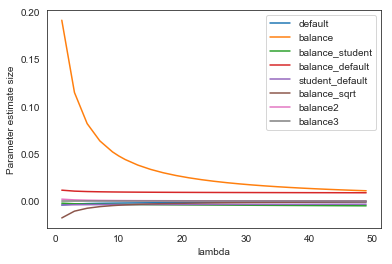

In [6]:
# Store estimates.
estimates = np.append(ridgeregrBig.coef_, [10])

# Storing legend information.
labels = []

#Run the model for many alphas.
for lambd in range(1, 50, 2):
    ridgeregrBig = linear_model.Ridge(alpha=lambd, fit_intercept=False)
    ridgeregrBig.fit(X_train2, Y_train)
    estimates = np.row_stack((
        estimates,
        np.append(ridgeregrBig.coef_,[lambd])))

# Make the data pretty.
estimates_df = pd.DataFrame(
    estimates,
    columns=list(X_train2.columns) + ['lambda'])
estimates_df.sort_values(by='lambda', inplace=True, ascending=True)

# Leave out the 'student' variable.
# It has very high values and throws off our plot's scale.
varstoplot = list(estimates_df.columns[:9,])
varstoplot.remove('student')

# Plot a line for each parameter.
for var in varstoplot:
    plt.plot(estimates_df['lambda'], estimates_df[var])
    labels.append(var)
plt.xlabel('lambda')
plt.ylabel('Parameter estimate size')
plt.legend(labels)
plt.show()

### Model 3. Lasso regression: Simple Model

In [7]:
# Small number of parameters.
lass = linear_model.Lasso(alpha=.35)
lassfit = lass.fit(X_train, Y_train)
print('R-squared for the model with few features:')
print(lass.score(X_train, Y_train))
origparams = np.append(lassfit.coef_, lassfit.intercept_)
print('\nParameter estimates for the model with few features:')
print(origparams)

R-squared for the model with few features:
0.450062579301185

Parameter estimates for the model with few features:
[-0.         -0.40657726 -0.          0.00114596]


### Model 4. Lasso regression: Complex Model

In [8]:
# Large number of parameters.
lassBig = linear_model.Lasso(alpha=.35)
lassBig.fit(X_train2, Y_train)
print('\nR-squared for the model with many features:')
print(lassBig.score(X_train2, Y_train))
origparams = np.append(lassBig.coef_, lassBig.intercept_)
print('\nParameter estimates for the model with many features:')
print(origparams)


R-squared for the model with many features:
0.44363376712897096

Parameter estimates for the model with many features:
[ 0.00000000e+00 -3.89351238e-01  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -2.77688887e-04
 -7.09158792e-07  3.48711577e+00]


## Regularization through cross-validation: Lasso

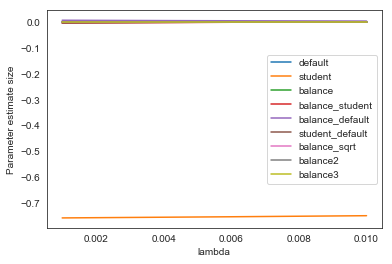

In [9]:
# Store estimates.
estimates = np.zeros((10,))

# Storing legend information.
labels = []

#Run the model for many alphas.
for lambd in np.linspace(0.001,0.01,10):
    lassBig = linear_model.Lasso(alpha=lambd, fit_intercept=False)
    lassBig.fit(X_train2, Y_train)
    estimates = np.row_stack((
        estimates,
        np.append(lassBig.coef_,[lambd])))
estimates = np.delete(estimates, 0, 0)
# Make the data pretty.
estimates_df = pd.DataFrame(
    estimates,
    columns=list(X_train2.columns) + ['lambda'])
estimates_df.sort_values(by='lambda', inplace=True, ascending=True)

varstoplot = list(estimates_df.columns[:9,])

# Plot a line for each parameter.
for var in varstoplot:
    plt.plot(estimates_df['lambda'], estimates_df[var])
    labels.append(var)
plt.xlabel('lambda')
plt.ylabel('Parameter estimate size')
plt.legend(labels)
plt.show()

All variables have almost zero coefficients with the lambda value 0.01. Only the student variable has very high values. I'll remove this feature and plot the result.

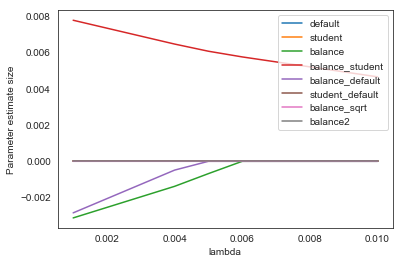

In [10]:
# Leave out the 'student' variable.
# It has very high values and throws off our plot's scale.
varstoplot = list(estimates_df.columns[:9,])
varstoplot.remove('student')
# Plot a line for each parameter.
for var in varstoplot:
    plt.plot(estimates_df['lambda'], estimates_df[var])
    labels.append(var)
plt.xlabel('lambda')
plt.ylabel('Parameter estimate size')
plt.legend(labels)
plt.show()

After removing the student variable, we can see that balance and balance_default features approach zero coefficient at lambda value 0.006. Next, I want to fit the Lasso model with lambda value 0.006 to see if the R-squared changes.

In [11]:
# Large number of parameters.
lassBig = linear_model.Lasso(alpha=.006)
lassBig.fit(X_train2, Y_train)
print('\nR-squared for the model with many features:')
print(lassBig.score(X_train2, Y_train))
origparams = np.append(lassBig.coef_, lassBig.intercept_)
print('\nParameter estimates for the model with many features:')
print(origparams)


R-squared for the model with many features:
0.5738522106120194

Parameter estimates for the model with many features:
[ 0.00000000e+00 -7.53355131e-01  0.00000000e+00 -0.00000000e+00
  5.71023574e-03 -0.00000000e+00  0.00000000e+00  1.40269685e-06
 -1.55943639e-09 -1.58646086e-02]


And yes! R-squared score increased 0.13 points

## Comparison: 𝑅2 across different values of  lambda  for Ridge & Lasso

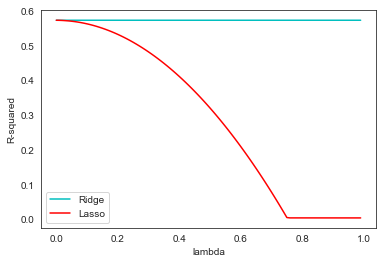

In [12]:
r2_lambda = []
for lambd in list(np.arange(0, 1, 0.01)): #np.linspace(0,1,0.01):
    ridgeBig = linear_model.Ridge(alpha = lambd)
    ridgeBig.fit(X_train2, Y_train)
    
    lassoBig = linear_model.Lasso(alpha = lambd, fit_intercept = False)
    lassoBig.fit(X_train2, Y_train)
    
    r2_lambda.append([ridgeBig.score(X_train2, Y_train), lassoBig.score(X_train2, Y_train), lambd])
r2_lambda = np.array(r2_lambda)

plt.plot(r2_lambda[:,2], r2_lambda[:,0], color = 'c', label = 'Ridge')
plt.plot(r2_lambda[:,2], r2_lambda[:,1], color = 'r', label = 'Lasso')
plt.xlabel('lambda')
plt.ylabel('R-squared')
plt.legend()

plt.show()

The graph shows that R-squared for Ridge model accross different values of lambda is more constant (it probably has some very small negative values) than that of Lasso. At lambda value 0.77 R-squared score for Lasso model is 0. 